# Pipeline Comparison

This notebook adds new pipeline metrics to the tracker TSV and optionally generates comparison plots.

In [1]:
# imports
import os
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.container import BarContainer

## Parameters

Set the paths to the metrics files and the new pipeline name.

In [12]:
# -----------------------
# Input parameters
# -----------------------

# Path to the gene metrics TSV from pipeline_qc
gene_metrics_path = "/Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/Hon_WTC11-benchmark_TF-Perturb-seq/runs/elated_almeida/pipeline_qc/mapping_gene/Hon_WTC11-benchmark_gene_metrics.tsv"

# Path to the guide metrics TSV from pipeline_qc
guide_metrics_path = "/Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/Hon_WTC11-benchmark_TF-Perturb-seq/runs/elated_almeida/pipeline_qc/mapping_guide/Hon_WTC11-benchmark_guide_metrics.tsv"

# Name for the new pipeline entry (e.g., "CRISPR Pipeline v0.0.4 (02/04/2026)")
new_pipeline_name = "CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026)"

# Path to the existing tracker TSV
tracker_path = "/Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/2026_02_04_pipeline_comparison.tsv"

# Whether to run the plotting code after updating
run_plots = True

## Load and Update Tracker

In [13]:
# -----------------------
# Load metrics files
# -----------------------
gene_df = pd.read_csv(gene_metrics_path, sep="\t")
guide_df = pd.read_csv(guide_metrics_path, sep="\t")

# Filter out the "all" row - we only want per-lane metrics
gene_df = gene_df[gene_df["batch"] != "all"].copy()
guide_df = guide_df[guide_df["batch"] != "all"].copy()

print(f"Gene metrics lanes: {gene_df['batch'].tolist()}")
print(f"Guide metrics lanes: {guide_df['batch'].tolist()}")

Gene metrics lanes: ['IGVFDS6244NAXC', 'IGVFDS8721BKRO', 'IGVFDS9332KWPJ', 'IGVFDS9613DDRB']
Guide metrics lanes: ['IGVFDS6244NAXC', 'IGVFDS8721BKRO', 'IGVFDS9332KWPJ', 'IGVFDS9613DDRB']


In [14]:
# -----------------------
# Build new rows from metrics
# -----------------------

# Merge gene and guide metrics on batch (lane)
merged = gene_df.merge(guide_df, on="batch", suffixes=("_gene", "_guide"))

# Create new rows matching tracker format
new_rows = []
for _, row in merged.iterrows():
    new_rows.append({
        "Lane": row["batch"],
        "Pipeline": new_pipeline_name,
        "Median Tx UMIs/cell": int(round(row["umi_median"])),
        "Median sgRNA UMIs/cell": int(round(row["guide_umi_median"])),
        "Singlets w/ sgRNA UMIs > 0": int(row["n_cells_with_guide"]),
        "Mean assigned sgRNA/cell": round(row["guides_per_cell_mean"], 2),
        "Singlets w/ exactly 1 sgRNA assigned": int(row["n_cells_exactly_1_guide"]),
    })

new_rows_df = pd.DataFrame(new_rows)
print(f"New rows to add ({len(new_rows_df)} lanes):")
new_rows_df

New rows to add (4 lanes):


,Lane,Pipeline,Median Tx UMIs/cell,Median sgRNA UMIs/cell,Singlets w/ sgRNA UMIs > 0,Mean assigned sgRNA/cell,Singlets w/ exactly 1 sgRNA assigned
0,IGVFDS6244NAXC,CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026),5475,1353,22373,1.57,13116
1,IGVFDS8721BKRO,CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026),4780,1249,21243,1.91,11752
2,IGVFDS9332KWPJ,CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026),4532,1121,20509,4.50,9173
3,IGVFDS9613DDRB,CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026),4615,1397,24483,1.67,13300


In [15]:
# -----------------------
# Load existing tracker and append new rows
# -----------------------
tracker_df = pd.read_csv(tracker_path, sep="\t")
print(f"Existing tracker has {len(tracker_df)} rows")

# Check if this pipeline already exists
if new_pipeline_name in tracker_df["Pipeline"].values:
    print(f"WARNING: Pipeline '{new_pipeline_name}' already exists in tracker!")
    print("Existing rows will be replaced.")
    tracker_df = tracker_df[tracker_df["Pipeline"] != new_pipeline_name]

# Append new rows
updated_df = pd.concat([tracker_df, new_rows_df], ignore_index=True)
print(f"Updated tracker has {len(updated_df)} rows")

Existing tracker has 20 rows
Updated tracker has 24 rows


In [16]:
# -----------------------
# Save updated tracker with new date
# -----------------------
tracker_dir = os.path.dirname(tracker_path)
today_str = datetime.now().strftime("%Y_%m_%d")
new_tracker_path = os.path.join(tracker_dir, f"{today_str}_pipeline_comparison.tsv")

updated_df.to_csv(new_tracker_path, sep="\t", index=False)
print(f"Saved updated tracker to: {new_tracker_path}")

# Display final table
updated_df

Saved updated tracker to: /Users/adamklie/Desktop/projects/tf_perturb_seq/datasets/technology-benchmark_WTC11_TF-Perturb-seq/results/2026_02_04_pipeline_comparison.tsv


,Lane,Pipeline,Median Tx UMIs/cell,Median sgRNA UMIs/cell,Singlets w/ sgRNA UMIs > 0,Mean assigned sgRNA/cell,Singlets w/ exactly 1 sgRNA assigned
0,IGVFDS9332KWPJ,Hon Lab Internal,5012,1446,22128,4.32,9473
1,IGVFDS8721BKRO,Hon Lab Internal,5351,1444,22408,2.03,10984
2,IGVFDS9613DDRB,Hon Lab Internal,5642,2000,25467,1.68,14422
3,IGVFDS6244NAXC,Hon Lab Internal,6358,1830,23675,1.60,14221
4,IGVFDS9332KWPJ,CRISPR Pipeline v0.0.1 (12/04/2025),4521,872,20896,5.03,7696
5,IGVFDS8721BKRO,CRISPR Pipeline v0.0.1 (12/04/2025),4799,926,22770,2.19,10924
6,IGVFDS9613DDRB,CRISPR Pipeline v0.0.1 (12/04/2025),4608,989,25404,2.02,11182
7,IGVFDS6244NAXC,CRISPR Pipeline v0.0.1 (12/04/2025),5467,1057,23103,1.85,11356
8,IGVFDS9332KWPJ,CRISPR Pipeline v0.0.2 (12/18/2025),4536,879,21096,5.04,7726
9,IGVFDS8721BKRO,CRISPR Pipeline v0.0.2 (12/18/2025),4203,693,12194,3.22,4944


## Comparison Plots

Generate faceted bar plots comparing metrics across pipelines.

In [17]:
if not run_plots:
    print("Skipping plots (run_plots=False)")
else:
    # -----------------------
    # Lane order + colors
    # -----------------------
    lane_order = ["IGVFDS9332KWPJ", "IGVFDS8721BKRO", "IGVFDS9613DDRB", "IGVFDS6244NAXC"]
    lane_colors = {
        "IGVFDS6244NAXC": "#1f77b4",
        "IGVFDS8721BKRO": "#ff7f0e",
        "IGVFDS9332KWPJ": "#2ca02c",
        "IGVFDS9613DDRB": "#d62728",
    }

In [18]:
if run_plots:
    # -----------------------
    # Prepare data for plotting
    # -----------------------
    wide = updated_df.rename(columns={
        "Lane": "lane",
        "Pipeline": "pipeline",
        "Median Tx UMIs/cell": "median_txn_umi_per_cell",
        "Median sgRNA UMIs/cell": "median_sgrna_umi_per_cell",
        "Singlets w/ sgRNA UMIs > 0": "gt0_sgrna",
        "Mean assigned sgRNA/cell": "mean_sgrna_per_cell",
        "Singlets w/ exactly 1 sgRNA assigned": "exactly1_sgrna",
    })

    # ensure numeric cols are numeric
    numeric_cols = [c for c in wide.columns if c not in ["lane", "pipeline"]]
    for c in numeric_cols:
        wide[c] = pd.to_numeric(wide[c], errors="coerce")

    # Metrics to facet
    metrics_to_plot = [
        "median_txn_umi_per_cell",
        "median_sgrna_umi_per_cell",
        "gt0_sgrna",
        "mean_sgrna_per_cell",
        "exactly1_sgrna",
    ]

    metric_labels = {
        "median_txn_umi_per_cell": "Median Tx UMIs/cell",
        "median_sgrna_umi_per_cell": "Median sgRNA UMIs/cell",
        "gt0_sgrna": "Singlets w/ sgRNA UMIs > 0",
        "mean_sgrna_per_cell": "Mean assigned sgRNA/cell",
        "exactly1_sgrna": "Singlets w/ exactly 1 sgRNA assigned",
    }

    df = wide.melt(
        id_vars=["lane", "pipeline"],
        value_vars=metrics_to_plot,
        var_name="metric",
        value_name="value",
    )
    df["metric"] = df["metric"].map(metric_labels)

    # Pipeline order + hatches (dynamically build from data)
    pipeline_order = wide["pipeline"].unique().tolist()
    
    # Predefined hatches, cycle if needed
    hatch_patterns = ["", "\\\\", "xx", "++", "//", "..", "oo", "**"]
    pipeline_hatches = {p: hatch_patterns[i % len(hatch_patterns)] for i, p in enumerate(pipeline_order)}
    
    print(f"Pipelines in order: {pipeline_order}")

Pipelines in order: ['Hon Lab Internal', 'CRISPR Pipeline v0.0.1 (12/04/2025)', 'CRISPR Pipeline v0.0.2 (12/18/2025)', 'CRISPR Pipeline v0.0.3 (01/06/2025)', 'CRISPR Pipeline v0.0.4 Sceptre (02/04/2026)', 'CRISPR Pipeline v0.0.4 CLEANSER (02/04/2026)']


/var/folders/tm/f8q3_wcj5s98dwjv86bvq7hr0000gn/T/ipykernel_22503/1436459034.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/var/folders/tm/f8q3_wcj5s98dwjv86bvq7hr0000gn/T/ipykernel_22503/1436459034.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/var/folders/tm/f8q3_wcj5s98dwjv86bvq7hr0000gn/T/ipykernel_22503/1436459034.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.barplot(
/var/folders/tm/f8q3_wcj5s98dwjv86bvq7hr0000gn/T/ipykernel_22503/1436459034.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  sns.b

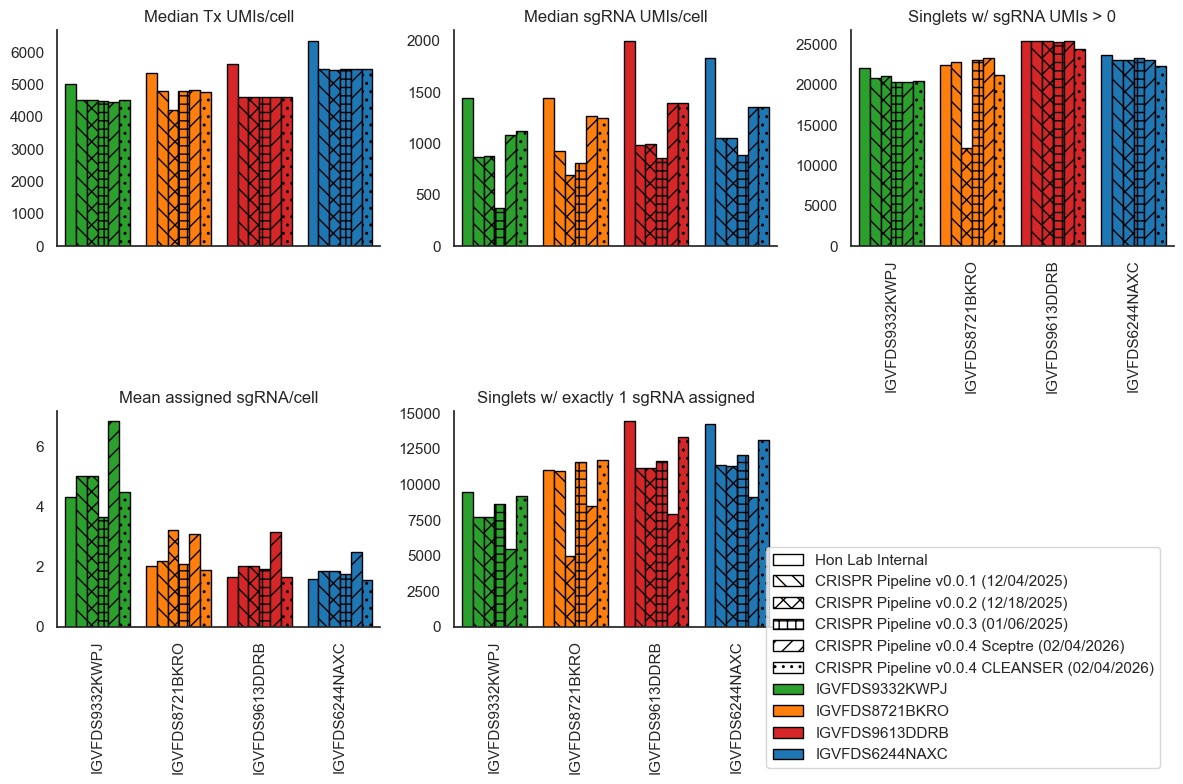

In [19]:
if run_plots:
    # -----------------------
    # Presentation-ish params
    # -----------------------
    plt.rcParams.update({
        "font.size": 16,
        "axes.titlesize": 24,
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    })
    sns.set(style="white")

    # -----------------------
    # Custom barplot: lane colors + pipeline hatches
    # -----------------------
    def barplot_with_lane_color_and_pipeline_hatch(data, x, y, hue, **kwargs):
        ax = plt.gca()

        sns.barplot(
            data=data,
            x=x,
            y=y,
            hue=hue,
            order=lane_order,
            hue_order=pipeline_order,
            dodge=True,
            edgecolor="black",
            **kwargs
        )

        # only bar containers (ignore errorbar containers)
        bar_containers = [c for c in ax.containers if isinstance(c, BarContainer)]

        # each container corresponds to one hue (pipeline), in hue_order
        for p_idx, container in enumerate(bar_containers):
            if p_idx >= len(pipeline_order):
                continue
            pipeline = pipeline_order[p_idx]

            for i, patch in enumerate(container.patches):
                if i >= len(lane_order):
                    continue
                lane = lane_order[i]
                patch.set_facecolor(lane_colors[lane])
                patch.set_hatch(pipeline_hatches[pipeline])

    # -----------------------
    # FacetGrid
    # -----------------------
    g = sns.FacetGrid(
        df,
        col="metric",
        col_wrap=3,
        sharey=False,
        height=4
    )

    g.map_dataframe(
        barplot_with_lane_color_and_pipeline_hatch,
        x="lane",
        y="value",
        hue="pipeline"
    )

    # axis cleanup
    for ax in g.axes.flatten():
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis="x", rotation=90)

    # remove per-axis legends
    for ax in g.axes.flatten():
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    # -----------------------
    # Legends: pipelines (hatch) + lanes (color)
    # -----------------------
    pipeline_handles = [
        Patch(facecolor="white", edgecolor="black", hatch=pipeline_hatches[p], label=p)
        for p in pipeline_order
    ]
    lane_handles = [
        Patch(facecolor=lane_colors[l], edgecolor="black", label=l)
        for l in lane_order
    ]
    all_handles = pipeline_handles + lane_handles

    g.fig.legend(
        handles=all_handles,
        loc="lower right",
        bbox_to_anchor=(0.98, 0.02),
        borderaxespad=0.5
    )

    g.set_titles("{col_name}")
    plt.tight_layout()
    plt.show()

# DONE!

---